In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
from collections import Counter
%matplotlib inline
import re 
import math
import time
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import KeyedVectors



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
RANDOM_SEED = 123
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda', index=0)

In [4]:

import pandas as pd

# read the text file and add the column names
new_file = pd.read_csv(r"/content/drive/My Drive/movies_genres_en.csv", sep='\t', encoding='utf-8')
new_file = new_file.iloc[:33000, :]
new_file.head()

,title,plot,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Game-Show,History,Horror,Music,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western,plot_lang
0,"""#7DaysLater"" (2013)",#7dayslater is an interactive comedy series f...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,en
1,"""#BlackLove"" (2015) {Crash the Party (#1.9)}","With just one week left in the workshops, the...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,en
2,"""#BlackLove"" (2015) {Making Lemonade Out of Le...",All of the women start making strides towards...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,en
3,"""#BlackLove"" (2015) {Miss Independent (#1.5)}",All five of these women are independent and s...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,en
4,"""#BlackLove"" (2015) {Sealing the Deal (#1.10)}",Despite having gone through a life changing p...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,en


In [5]:
from sklearn.utils import shuffle
new_file = shuffle(new_file)
new_file = new_file.reset_index(drop=True)
new_file.iloc[:4, :5]

,title,plot,Action,Adult,Adventure
0,"""Canada's Worst Driver"" (2005) {(#2.1)}",Unlike season 1 where the driving challenges ...,0,0,0
1,"""Binnenstebuiten"" (2013) {Als de rook om je ho...",A patient diagnosed with long cancer rudely r...,0,0,0
2,"""Ask 1iota"" (2016) {I Have Tickets Available.....",If you have tickets available in your account...,0,0,0
3,"""Beetleborgs Metallix"" (1997) {The Curse of th...",Mums' Mommy arrives at Hillhurst and gives Mu...,1,0,0


  ## Encoding the Labels##




In [6]:
one_hot = new_file.iloc[:, 2:-1]
one_hot.head()

,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Game-Show,History,Horror,Music,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


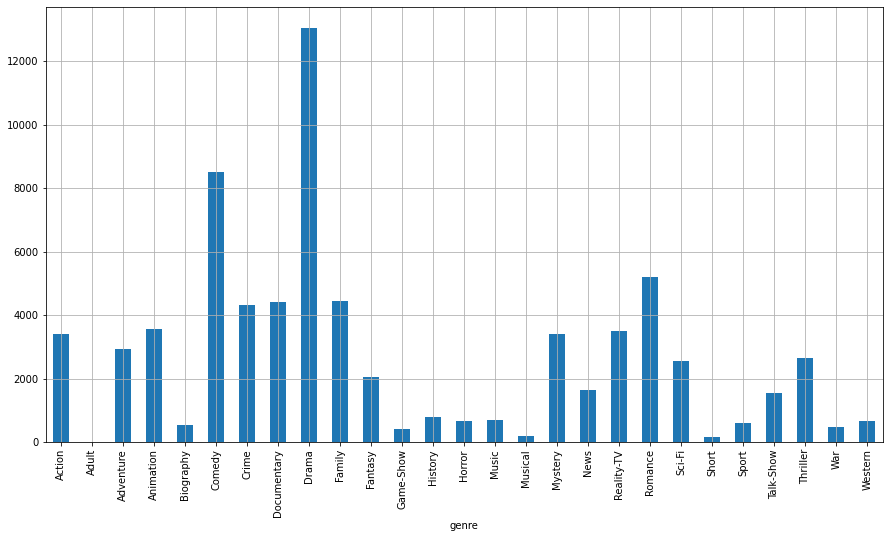

In [7]:
#plot the frequency of the each genre

counts = []
categories = list(one_hot.columns.values)
for i in categories:
    counts.append((i, one_hot[i].sum()))
df_stats = pd.DataFrame(counts, columns=['genre', '#movies'])
df_stats
df_stats.plot(x='genre', y='#movies', kind='bar', legend=False, grid=True, figsize=(15, 8))

## Text preprocessing##

In [8]:

movie_plots = new_file['plot']
plot_list = [plot for plot in movie_plots]
plot_num = len(plot_list)
print("the total number of movies: {}\n".format(plot_num))

all_docs = []
i_index = 0

for doc in plot_list:
    # Tokenize the string into words
    tokens = word_tokenize(doc)
    # Remove non-alphabetic tokens, such as punctuation
    words = [word.lower() for word in tokens if word.isalpha()]
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if not word in stop_words]

    # get rid of the items with words less than 5
    if len(words) >= 5:
      all_docs.append(words)
    else:
      one_hot = one_hot.drop(i_index, axis=0)
    
    i_index += 1
  

one_hot = one_hot.reset_index(drop=True)

the total number of movies: 33000



## Word Embedding ##

In [9]:
#custom trained word embedding method

import multiprocessing
import gensim
from gensim.models import Word2Vec


workers = multiprocessing.cpu_count()
print('number of cpu: {}'.format(workers))

word_model = Word2Vec(all_docs,
                      min_count=1,
                      size=300,
                      window=5,
                      workers=4,
                      iter=100)



number of cpu: 4


In [31]:
#get word embeddings
   
all_words = [ word for doc in all_docs for word in doc]
all_words_nodup = list(dict.fromkeys(all_words))

# Load word2vec model (trained on an enormous Google corpus)
# google_vecs = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary = True) /Colab Notebooks
embedded_model = KeyedVectors.load_word2vec_format('/content/drive/My Drive/GoogleNews-vectors-negative300.bin', binary = True)
embedding_dim_dim = embedded_model.vector_size

def words_embedding(doc):
    # get the vector of each word in the doc, using different model
    #vector_list = [google_vecs[word] for word in doc if word in google_vecs.vocab]
    vector_list = [word_model.wv[word] for word in doc]
  

    # Create a list of the words corresponding to these vectors
    words_filtered = [word for word in doc ]
    #words_filtered = [word for word in doc if word in google_vecs.vocab] 

    #Zip the words together with their vector representations
    word_vec_zip = zip(words_filtered, vector_list)

    # Cast to a dict so we can turn it into a DataFrame
    word_vec_dict = dict(word_vec_zip)
    word_vec = pd.DataFrame.from_dict(word_vec_dict, orient='index')
    return word_vec

# get all the word vectors in the whole dataset
word_vec  = words_embedding(all_words_nodup)
word_vec_array = np.array(word_vec)

# insert a row as the vector of padding 0
word_vec_array = np.insert(word_vec_array, 0, np.zeros(word_vec_array.shape[1]), 0)
word_vec.shape

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


(69204, 300)

In [0]:
# word_vec.to_csv(r'./wor_vec.csv', index=False)

In [0]:
#word_vec = pd.read_csv(r"/content/drive/My Drive/Colab Notebooks/final project/wor_vec.csv", header=None)

# Generate the integer vectors of all plots

In [0]:
word_index = pd.DataFrame(index = word_vec.index)
wordlen_list = range(1, word_vec.shape[0]+1)
word_index['index'] = wordlen_list

def words_index(all_docs):
    all_words_index = []
    for doc in all_docs:
        inds = []
        for word in doc:
            try:
                inds.append(word_index.at[word, 'index'])
            except: 
                continue
            
        all_words_index.append(inds)
    return all_words_index

all_words_index = words_index(all_docs)


# Mechine learning model with different word embedding methods

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB

# define KNN Classifier
def KNN(input):
    X = input
    y = one_hot.values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
    

    neigh = KNeighborsClassifier(n_neighbors=3)
    neigh.fit(X_train, y_train)
    print(X_test.shape)
    y_pred = neigh.predict(X_test)

    print('Testing accuracy %s' % (1- np.count_nonzero(np.abs(y_test-y_pred))/(y_pred.shape[0]*y_pred.shape[1])))
    print('Testing F1 score: {}'.format(precision_recall_fscore_support(y_test, y_pred, average='micro', zero_division=0)[:3]))



In [15]:
# average word embedding as a 

doc_vec = []
for doc in all_docs:
    if len(doc) != 0:
      w2c_list = [embedded_model[word]  for word in doc  if word in embedded_model.vocab] 
      doc_vec.append(np.mean(np.array(w2c_list), axis=0))

plot_vec = np.array(doc_vec)

KNN(plot_vec)

(4950, 300)
Testing accuracy 0.9323531612420501
Testing F1 score: (0.5860017001983565, 0.571165531209722, 0.5784885076227331)


In [16]:
#TF-IDF weighted embedding 

from sklearn.feature_extraction.text import TfidfVectorizer

#def tf_dif(doc):
all_text_docs = []

for doc in all_docs:
    all_text_docs.append(" ". join(doc))

tf_idf_vect = TfidfVectorizer(stop_words='english', max_features=5000, )
# get the TF-IDF value for each word
final_tf_idf = tf_idf_vect.fit_transform(all_text_docs)
tfidf_feat = tf_idf_vect.get_feature_names()
doc_dict = dict(zip(tfidf_feat, list(tf_idf_vect.idf_)))
  

tfidf_doc_vectors_ft = [] 
row=0
errors=0
for doc in all_docs: 
    doc_vec = np.zeros(300) 
    weight_sum =0;

    for word in doc: 
        try:
            vec = word_model.wv[word]
            # obtain the tf_idf of words in a plot
            tfidf = doc_dict[word]*(doc.count(word)/len(doc))#final_tf_idf[row, tfidf_feat.index(word)]
            doc_vec += (vec * tfidf)
            weight_sum += tfidf
        except:
            errors += 1
            pass

    # if weight_sum == 0 : 
    #     print(row)
    #     doc_vec = words_embedding(doc)
    # #     doc_vec = np.mean(np.array(doc_vec), axis = 0)
    # else:
    #      # print(np.where(np.isnan(tfidf_doc_vectors_ft_array)))
    doc_vec = doc_vec/weight_sum
      
  
    tfidf_doc_vectors_ft.append(doc_vec)
    row += 1

tfidf_doc_vectors_ft_array = np.array(tfidf_doc_vectors_ft)
# tfidf_doc_vectors_ft_array = np.concatenate((tfidf_doc_vectors_ft_array, plot_vec), axis = 1)
KNN(tfidf_doc_vectors_ft_array)

(4950, 300)
Testing accuracy 0.9480359147025814
Testing F1 score: (0.7185581966298404, 0.5928005892100903, 0.6496493971649095)


In [17]:

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn import utils

all_labels = one_hot.values
def doc2vec(all_docs, all_labels):
    
    plot_tags = []
    for (doc, labels) in zip(all_docs, all_labels):
         plot_tags.append(TaggedDocument(doc, labels))
 
    doc_model = Doc2Vec(dm=1, 
                        vector_size=300, 
                        negative=5, 
                        hs=0, 
                        min_count=2, 
                        sample=0, 
                        workers=workers)
    doc_model.build_vocab(plot_tags)
    for epoch in range(30):
        doc_model.train(utils.shuffle(plot_tags), total_examples=new_file.shape[0], epochs=1)
        doc_model.alpha -= 0.002
        doc_model.min_alpha = doc_model.alpha
        doc_model.train(utils.shuffle(plot_tags), total_examples=new_file.shape[0], epochs=1)
        
    
    targets, doc_vec = zip(*[(doc.tags, doc_model.infer_vector(doc.words, steps=20)) for doc in plot_tags])
    return targets, doc_vec

targets, doc_vec = doc2vec(all_docs, all_labels)
KNN(np.array(doc_vec))

(4950, 300)
Testing accuracy 0.9189674523007856
Testing F1 score: (0.5023612750885478, 0.31338611673724914, 0.3859848055335072)


In [18]:
pip install adjustText

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


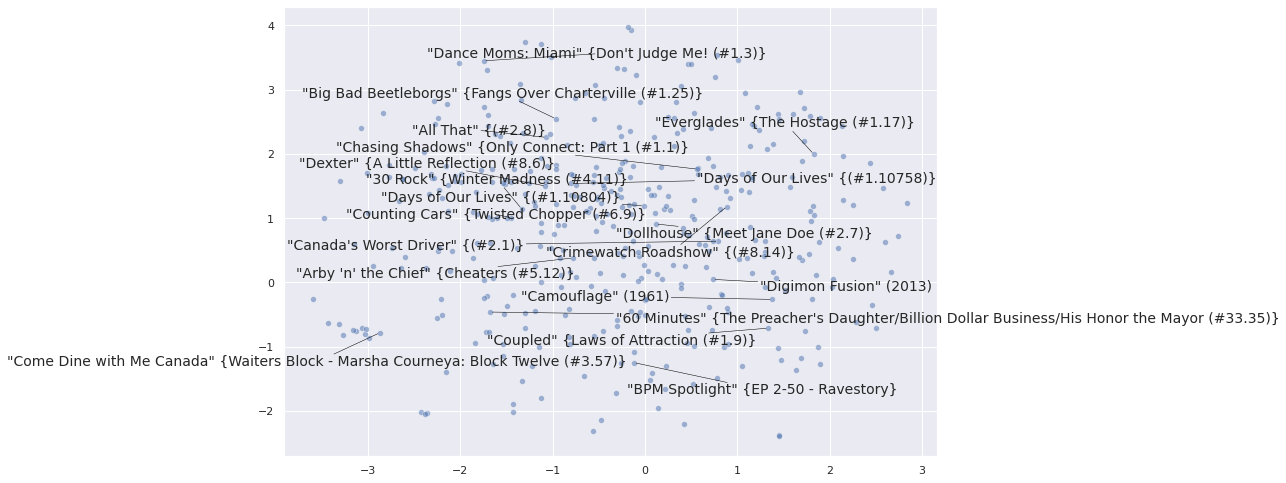

In [19]:
from sklearn.manifold import TSNE
from adjustText import adjust_text
import seaborn as sns

movie_title = new_file['title'].str.replace(r'\(\S*\s', '')
 
titles_list = [title for title in movie_title]
titles_list = titles_list[:400]
def t_SNE_plot(df_data):
    # Initialize t-SNE
    tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

    # Use only 400 rows to shorten processing time
    tsne_df = tsne.fit_transform(df_data)#tsne.fit_transform(df_data[:400])

    sns.set()
    # Initialize figure
    fig, ax = plt.subplots(figsize = (11.7, 8.27))
    sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

    # Import adjustText, initialize list of texts

    texts = []
    data_to_plot = list(np.arange(0, 400, 20))#list(np.arange(0, 400, 40))

    # Append words to list
    for data in data_to_plot:
        texts.append(plt.text(tsne_df[data, 0], tsne_df[data, 1], titles_list[data], fontsize = 14))

    # Plot text using adjust_text (because overlapping text is hard to read)
    adjust_text(texts, force_points = 0.4, force_text = 0.4, 
                expand_points = (2,1), expand_text = (1,2),
                arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

    plt.show()

    return tsne_df

tsne_df = t_SNE_plot(plot_vec[:400, :])    

## Padding sequences

In [20]:
#get the max length for all plot 
max_Length = 0  
docs_length = []
for x in all_words_index:
    docs_length.append(len(x))
    if len(x) > max_Length:
        max_Length = len(x)

docs_length = np.array(docs_length)
max_Length

610

In [0]:
def pad_sequences(all_words_index, seq_length):
    
    # getting the correct rows x cols shape
    sequences = np.zeros((len(all_words_index), seq_length), dtype=int)
 
    # for each review, I grab that review and 
    for i, row in enumerate(all_words_index):
        if len(row)>0:
            sequences[i, 0:len(row)] =  np.array(row)[:seq_length]
    
    return sequences

sequences = pad_sequences(all_words_index, max_Length)

assert len(sequences)==len(all_words_index), "Sequences should have as many rows as reviews."
assert len(sequences[0])==max_Length, "Each sequence row should contain seq_length values."

# Training, Validation, and Test Data

In [22]:
split_frac = 0.7

# split data into training, validation, and test data (features and labels, x and y)

split_idx = int(len(sequences)*split_frac)
train_x, remaining_x = sequences[:split_idx], sequences[split_idx:]
train_y, remaining_y = one_hot[:split_idx], one_hot[split_idx:]
train_len, remaining_len = docs_length[:split_idx], docs_length[split_idx:]

# train_x, remaining_x = sequences[:10000], sequences[-4000:]
# train_y, remaining_y = one_hot[:10000], one_hot[-4000:]
# train_len, remaining_len = docs_length[:10000], docs_length[-4000:]

test_idx = int(len(remaining_x)*0.5)
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]
val_len, test_len = remaining_len[:test_idx], remaining_len[test_idx:]

# print out the shapes of your resultant feature data
print("\t\t\tSequences Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))


			Sequences Shapes:
Train set: 		(23100, 610) 
Validation set: 	(4950, 610) 
Test set: 		(4950, 610)


# DataLoaders and Batching

In [0]:
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(np.array(train_x)), torch.from_numpy(np.array(train_y).astype(np.int16)), torch.from_numpy(train_len)) 
valid_data = TensorDataset(torch.from_numpy(np.array(val_x)), torch.from_numpy(np.array(val_y).astype(np.int16)), torch.from_numpy(val_len))
test_data = TensorDataset(torch.from_numpy(np.array(test_x)), torch.from_numpy(np.array(test_y).astype(np.int16)), torch.from_numpy(test_len)) 

batch_size = 128

# shuffling and batching data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=4)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size, num_workers=4)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, num_workers=4)

# Deep learning models

In [0]:
# attention method

class Attention(nn.Module):
    def __init__(self, hidden_size, batch_first=False):
        super(Attention, self).__init__()

        self.hidden_size = hidden_size
        self.batch_first = batch_first

        self.att_weights = nn.Parameter(torch.Tensor(1, hidden_size), requires_grad=True)

        stdv = 1.0 / np.sqrt(self.hidden_size)
        for weight in self.att_weights:
            nn.init.uniform_(weight, -stdv, stdv)

    def get_mask(self):
        pass

    def forward(self, inputs, lengths):
        if self.batch_first:
            batch_size, max_len = inputs.size()[:2]
        else:
            max_len, batch_size = inputs.size()[:2]
            
        # apply attention layer
        weights = torch.bmm(inputs,
                            self.att_weights  # (1, hidden_size)
                            .permute(1, 0)  # (hidden_size, 1)
                            .unsqueeze(0)  # (1, hidden_size, 1)
                            .repeat(batch_size, 1, 1) # (batch_size, hidden_size, 1)
                            )
    
        attentions = torch.softmax(torch.tanh(weights.squeeze()), dim=-1)

        # create mask based on the sentence lengths
        mask = torch.ones(attentions.size(), requires_grad=True).cuda()
        for i, l in enumerate(lengths):  # skip the first sentence
            if l < max_len:
                mask[i, l:] = 0

        # apply mask and renormalize attention scores (weights)
        masked = attentions * mask
        _sums = masked.sum(-1).unsqueeze(-1)  # sums per row
        
        attentions = masked.div(_sums)

        # apply attention weights
        weighted = torch.mul(inputs, attentions.unsqueeze(-1).expand_as(inputs))

        # get the final fixed vector representations of the sentences
        representations = weighted.sum(1).squeeze()

        return representations, attentions

In [0]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# def kmax_pooling(x, dim, k):
#     index = x.topk(k, dim = dim)[1].sort(dim = dim)[0]
#     return x.gather(dim, index)

class LSTMText(torch.nn.Module): 
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, 
                linear_hidden_size, num_classes, freeze_embeddings=True):
        super(LSTMText, self).__init__()
        
        # 1. embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # set weights to pre-trained
        self.embedding.weight = nn.Parameter(torch.from_numpy(word_vec_array)) # all vectors
        # (optional) freeze embedding weights
        if freeze_embeddings:
            self.embedding.requires_grad = False

        self.lstm =nn.LSTM( input_size = embedding_dim,
                            hidden_size = hidden_size,
                            num_layers = num_layers,
                            bias = True,
                            batch_first = True,
                            dropout = 0.5,
                            bidirectional = True
                            )
        self.atten = Attention(hidden_size*2, batch_first=True) # 2 is bidrectional
       
        self.fc = nn.Sequential(
            nn.Dropout(),
            nn.Linear(hidden_size*2, linear_hidden_size), #linear_hidden_size
            nn.BatchNorm1d(linear_hidden_size),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(linear_hidden_size, num_classes)
        )
        
         #activation function
        self.act = nn.Sigmoid()
 
    def forward(self, text, text_lengths):
      
        #text = [batch size,sent_length, emb_dim]
        embedded = self.embedding(text)
        #embedded = [batch size, sent_len, emb dim]
        
        #packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths, batch_first=True, enforce_sorted=False)
        
        #hidden = [batch size, num layers * hidden_size, emb_dim]
        #cell = [batch size, num layers * hidden_size, emb_dim]
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        
        text, text_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        
        
        text, _ = self.atten(text, text_lengths) 
        # print('text: ', text.size())

        #concat the final forward and backward hidden state
        #hidden = torch.cat([x, y], dim=1)
        # hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
                
        logits=self.fc(text)
        # reshaped = hidden.view( hidden.size(0), -1)
        # logits=self.fc(hidden) #.view(len(text),-1)

        #Final activation function
        probas=self.act(logits)

        return logits, probas


In [0]:


import numpy as np
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# def kmax_pooling(x, dim, k):
#     index = x.topk(k, dim = dim)[1].sort(dim = dim)[0]
#     return x.gather(dim, index)

class TextCNN(torch.nn.Module): 
    def __init__(self, vocab_size, embedding_dim, covhidden_dim, kernel_sizes,
                 num_classes, freeze_embeddings=True):
        super(TextCNN, self).__init__()
        
        # 1. embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # set weights to pre-trained
        self.embedding.weight = nn.Parameter(torch.from_numpy(word_vec_array)) # all vectors
        # (optional) freeze embedding weights
        if freeze_embeddings:
            self.embedding.requires_grad = False

        # 2. convolutional layers
        self.convs = nn.ModuleList([
                nn.Sequential(nn.Conv1d(in_channels = embedding_dim, 
                                        out_channels = covhidden_dim, 
                                        kernel_size = h),
                              nn.BatchNorm1d(covhidden_dim), 
                              nn.ReLU(),
                              nn.MaxPool1d(kernel_size = max_Length-h+1))
                     for h in kernel_sizes
                    ])
        
        
        self.fc = nn.Sequential(
                nn.Dropout(),
                nn.Linear(len(kernel_sizes) * covhidden_dim, linear_hidden_size),
                nn.BatchNorm1d(linear_hidden_size),
                nn.Dropout(),
                nn.ReLU(inplace=True),
                nn.Linear(linear_hidden_size,num_classes)
        )

      
        self.dropout = nn.Dropout()
        self.act = nn.Sigmoid()

 
    def forward(self, text):
      
      #text = [batch size,sent_length， emb_dim]
      embedded = self.embedding(text)

      #embedded = [batch size, emb dim, sent_len]
      embedded = embedded.permute(0, 2, 1)
      
      # get results for each kernel siza
      conv_results = [conv(embedded) for conv in self.convs]
     
      # concatenate results and add dropout
      text = torch.cat(conv_results, dim = 1)
      text = self.dropout(text)
      text = text.view(-1, text.size(1)) 
      # final logit
      logits = self.fc(text) 

      #Final activation function
      probas=self.act(logits)

      return logits, probas


In [0]:
def kmax_pooling(x, dim, k):
    index = x.topk(k, dim = dim)[1].sort(dim = dim)[0]
    return x.gather(dim, index)

class RCNN(torch.nn.Module): 
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, covhidden_dim, 
                linear_hidden_size, kernel_sizes, num_classes, freeze_embeddings=True ):
        super(RCNN, self).__init__()
        
        # self.kernel_size = kernel_size #[2,3,4]
        self.kmax_pooling = kmax_pooling
        # 1. embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # set weights to pre-trained
        self.embedding.weight = nn.Parameter(torch.from_numpy(word_vec_array)) # all vectors
        # (optional) freeze embedding weights
        if freeze_embeddings:
            self.embedding.requires_grad = False

        self.lstm =nn.LSTM( input_size = embedding_dim,
                            hidden_size = hidden_size,
                            num_layers = num_layers,
                            bias = True,
                            batch_first = True,
                            dropout = 0.5,
                            bidirectional = True
                            )
  

         # 2. convolutional layers
        self.convs = nn.ModuleList([
                nn.Sequential(nn.Conv1d(in_channels = hidden_size*2, 
                                        out_channels = covhidden_dim, 
                                        kernel_size = h),
                              nn.BatchNorm1d(covhidden_dim), 
                              nn.ReLU(),
                              nn.MaxPool1d(kernel_size = max_Length-h+1))
                     for h in kernel_sizes
                    ])
   
         
        self.fc = nn.Sequential(
            nn.Dropout(),
            nn.Linear(covhidden_dim*len(kernel_sizes), linear_hidden_size),
            nn.BatchNorm1d(linear_hidden_size),
            nn.Dropout(),
            nn.ReLU(inplace=True),
            nn.Linear(linear_hidden_size,num_classes)
        )
        # self.fc = nn.Linear(3 * (opt.title_dim+opt.content_dim), opt.num_classes)
        self.dropout = nn.Dropout()
        self.act = nn.Sigmoid()
 
    def forward(self, text, text_lengths):
        # print(text.shape)
        embedded = self.embedding(text)
       
        packed_output, (hidden, cell) = self.lstm(embedded)
        
        text = packed_output.permute(0, 2, 1)
        # print(text.shape)
        conv_results = [conv(text) for conv in self.convs]
        
      
        # concatenate results and add dropout
        out = torch.cat(conv_results, dim = 1)
        out = self.dropout(out)
        # print(out.shape)
        out = out.view(-1, out.size(1)) 
        # print(out.shape)
          
        # reshaped = conv_out.view(conv_out.size(0), -1)
        logits = self.fc(out)
        probas=self.act(logits)
        return logits, probas

In [0]:
class MyEnsemble(nn.Module):
    def __init__(self, modelA, modelB, modelC):
        super(MyEnsemble, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.modelC = modelC
        
    def forward(self, text, text_lengths):
        output11, output12 = self.modelA(text, text_lengths)
        output21, output22 = self.modelB(text)
        output31, output32 = self.modelC(text, text_lengths)
        x = (output12 + output22 + output32)/3
        return x

# Instantiate the network

In [43]:
  # Instantiate the model with hyperparameters

import random

vocab_size = word_vec.shape[0]+1

embedding_dim = word_vec.shape[1]
hidden_size = 256 
num_layers=2 
linear_hidden_size = 100 # units number of full connected 
num_classes = one_hot.shape[1]
num_filters = 1000
kernel_sizes = [3, 4, 5]
kmax_pooling = 2
covhidden_dim = 100

# random.seed(RANDOM_SEED)
# torch.manual_seed(RANDOM_SEED)  ###revise


model = LSTMText(vocab_size, embedding_dim, hidden_size, num_layers, 
                 linear_hidden_size, num_classes)

# model = TextCNN(vocab_size, embedding_dim, covhidden_dim, kernel_sizes,
                #  num_classes)

# model = RCNN(vocab_size, embedding_dim, hidden_size, num_layers, covhidden_dim,
#                  linear_hidden_size, kernel_sizes, num_classes) 



# # Load state dicts
# model1.load_state_dict(torch.load('drive/My Drive/model1.pth'))
# model2.load_state_dict(torch.load('drive/My Drive/model2.pth'))
# model3.load_state_dict(torch.load('drive/My Drive/model3.pth'))
# model = MyEnsemble(model1, model2, model3)


model = model.float()

print(model)
model = model.to(DEVICE)


# No. of trianable parameters
def count_parameters(model):
    return sum(m.numel() for m in model.parameters() if m.requires_grad)
 
print(f'The model has {count_parameters(model):,} trainable parameters')


LSTMText(
  (embedding): Embedding(69205, 300)
  (lstm): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (atten): Attention()
  (fc): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=512, out_features=100, bias=True)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=100, out_features=27, bias=True)
  )
  (act): Sigmoid()
)
The model has 23,535,983 trainable parameters


In [0]:
NUM_EPOCHS = 40
intial_lr = 0.1
criterion = nn.BCELoss() 
       
optimizer = torch.optim.SGD(model.parameters(), lr=intial_lr, weight_decay=7e-4, momentum=0.9) #Adam 

# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,
#                                                    gamma=0.1,
#                                                    last_epoch=-1)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 15, gamma=0.5, last_epoch=-1)


# Define loss function and evaluation parameters and Train

In [0]:
from sklearn.metrics import multilabel_confusion_matrix
def compute_accuracy_and_loss(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    loss = 0.
    accuracy_list = []
    f_measure_list = []
    list_prob = []
    predicted = np.zeros((1, one_hot.shape[1]))
    targets_loader = np.zeros((1, one_hot.shape[1]))
    for i, (features, targets, features_len) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)
        features_len = features_len.to(device)

 
        logits, probas = model(features, features_len)
        
        loss += criterion(probas, targets.float()).item()

        # targets_arr = targets.cpu().numpy()
        # # print(targets_arr)
        # targets_num = np.count_nonzero(targets_arr, axis=1)
        # # print(targets_num)
        # probas_arr = probas.cpu().numpy() 
        # predicted_labels = np.zeros(probas_arr.shape)
        # for i in range(probas_arr.shape[0]):
        #   target_index = np.argsort(probas_arr[i, :])[-targets_num[i]:]
        #   for j in target_index:
        #     predicted_labels[i, j] = 1

        predicted_labels = (probas > 0.5).cpu().numpy().astype(np.uint8)#(probas > 0.4).cpu().numpy()
       
        # print('target:', targets[:10])
        # print('probas:', probas[:10])
        # print(predicted_labels)

        predicted = np.concatenate((predicted,predicted_labels), axis=0)
        targets_loader = np.concatenate((targets_loader, targets.cpu().numpy()), axis=0)
     
        num_examples += targets.size(0)
        # print(num_examples)
        # accuracy_list.append(accuracy_score(targets.cpu().numpy(), predicted_labels))
        # f_measure_list.append(list(precision_recall_fscore_support(targets.cpu().numpy(), predicted_labels,average='micro')[:3]))
    average_loss = loss/ num_examples
    predicted = predicted[1:, :]
    targets_loader = targets_loader[1:, :]
    accuracy_all = 1- np.count_nonzero(np.abs(targets_loader - predicted))/(predicted.shape[0]*predicted.shape[1])#accuracy_score(targets_loader, predicted)
    accuracy_class = [accuracy_score(targets_loader[:, i], predicted[:, i]) for i in range(one_hot.shape[1])]
    # print(accuracy_class.dtype)
    accuracy_class_average = np.mean(np.array(accuracy_class))
    # print('target:', targets_loader[])
    # print('probas:', probas)
    f_measure = precision_recall_fscore_support(targets_loader, predicted, average='micro', zero_division=0)[:3]
    confusion_matrix = multilabel_confusion_matrix(targets_loader, predicted)
    
    # accuracy = accuracy_score(targets.cpu().numpy(), predicted_labels)
    # f_measure = precision_recall_fscore_support(targets.cpu().numpy(), predicted_labels,average='weighted')
    # accuracy = np.mean(np.array(accuracy_list))
    # f_measure = np.mean(np.array(f_measure_list), axis = 0)
    return accuracy_all, average_loss, f_measure, accuracy_class_average, accuracy_class, confusion_matrix

In [46]:
   
start_time = time.time()
train_acc_lst, valid_acc_lst = [], []
train_loss_lst, valid_loss_lst = [], []

for epoch in range(NUM_EPOCHS):
    
    model.train()
    
    for batch_idx, (features, targets, features_len) in enumerate(train_loader): #, 

        ### PREPARE MINIBATCH
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
        features_len = features_len.to(DEVICE)

            
        ### FORWARD AND BACK PROP
        # features = features.view(features.size(0), -1)
        logits, probas = model(features, features_len)

        cost = criterion(probas, targets.float())
        optimizer.zero_grad()

        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        # model.apply(weights_init)
        ### LOGGING
        if not batch_idx % 20:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')
        if not epoch % 15 and epoch != 0:
            scheduler.step()
        
    # no need to build the computation graph for backprop when computing accuracy
    model.eval()
    with torch.set_grad_enabled(False):
        train_acc, train_loss, train_f_measure, train_ave, train_class, train_matrix = compute_accuracy_and_loss(model, train_loader, device=DEVICE)
        valid_acc, valid_loss, valid_f_measure, valid_ave, valid_class, valid_matrix = compute_accuracy_and_loss(model, valid_loader, device=DEVICE)
        train_acc_lst.append(train_acc)
        valid_acc_lst.append(valid_acc)
        train_loss_lst.append(train_loss), features_len
        valid_loss_lst.append(valid_loss)
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Train Acc.: {train_acc:.2f}'
              f' | Validation Acc.: {valid_acc:.2f}')

    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
    print('the precision_recall_fscore_support of F-score_train: ', train_f_measure)
    print('the precision_recall_fscore_support of F-score_val: ', valid_f_measure)
    print('the train average: ', train_ave)
    print('the valid average: ', valid_ave)
    print('the train class: ', train_class)
    print('the valid class: ', valid_class)
    print('the train matrix: ', train_matrix)
    print('the valid matrix: ', valid_matrix)





Streaming output truncated to the last 5000 lines.

 [[4870    0]
  [  80    0]]

 [[4700   18]
  [ 164   68]]

 [[4566   14]
  [ 351   19]]

 [[4869    0]
  [  81    0]]

 [[4854    0]
  [  82   14]]]
Epoch: 013/040 | Batch 000/181 | Cost: 0.1593
Epoch: 013/040 | Batch 020/181 | Cost: 0.1843
Epoch: 013/040 | Batch 040/181 | Cost: 0.1679
Epoch: 013/040 | Batch 060/181 | Cost: 0.1603
Epoch: 013/040 | Batch 080/181 | Cost: 0.1643
Epoch: 013/040 | Batch 100/181 | Cost: 0.1672
Epoch: 013/040 | Batch 120/181 | Cost: 0.1528
Epoch: 013/040 | Batch 140/181 | Cost: 0.1677
Epoch: 013/040 | Batch 160/181 | Cost: 0.1590
Epoch: 013/040 | Batch 180/181 | Cost: 0.1527
Epoch: 013/040 Train Acc.: 0.94 | Validation Acc.: 0.94
Time elapsed: 8.14 min
the precision_recall_fscore_support of F-score_train:  (0.7609166610249813, 0.4439507050598412, 0.5607413689882259)
the precision_recall_fscore_support of F-score_val:  (0.7433915597464832, 0.447016174010039, 0.5583096302316132)
the train average:  0.94353375

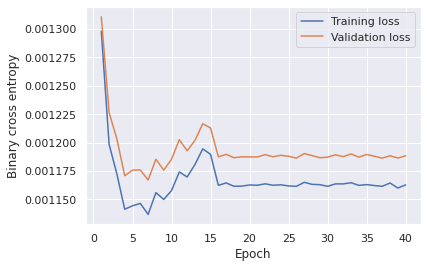

In [47]:
plt.plot(range(1, NUM_EPOCHS+1), train_loss_lst, label='Training loss')
plt.plot(range(1, NUM_EPOCHS+1), valid_loss_lst, label='Validation loss')
plt.legend(loc='upper right')
plt.ylabel('Binary cross entropy')
plt.xlabel('Epoch')
plt.show()

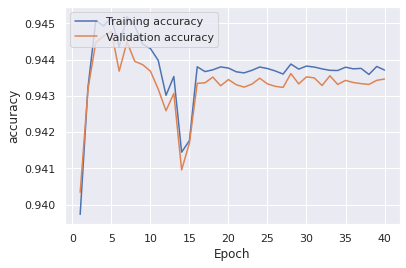

Training accuracy: 0.94%
Validation accuracy: 0.94%


In [48]:
plt.plot(range(1, NUM_EPOCHS+1), train_acc_lst, label='Training accuracy')
plt.plot(range(1, NUM_EPOCHS+1), valid_acc_lst, label='Validation accuracy')
plt.legend(loc='upper left')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.show()
print(f'Training accuracy: {train_acc_lst[-1]:.2f}%')
print(f'Validation accuracy: {valid_acc_lst[-1]:.2f}%')

In [49]:

model.eval()
with torch.set_grad_enabled(False): # save memory during inference
    test_acc, test_loss, test_f_measure, test_ave, test_class, test_matrix = compute_accuracy_and_loss(model, test_loader, DEVICE)
    print(f'Test accuracy: {test_acc:.2f}%')
    print(test_f_measure)

Test accuracy: 0.94%
(0.7810782967032966, 0.41395941395941394, 0.5411288883601975)


In [0]:
torch.save(model.state_dict(), 'drive/My Drive/model1.pth')

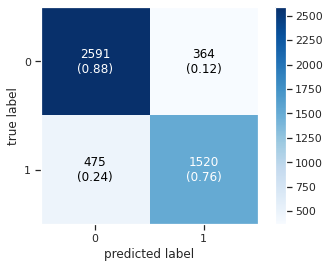

In [50]:
#plot the confusion matrix for "drama"

from mlxtend.plotting import plot_confusion_matrix
class_names = ['Drama', 'others']
fig, ax = plot_confusion_matrix(conf_mat=test_matrix[8, :, :],
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

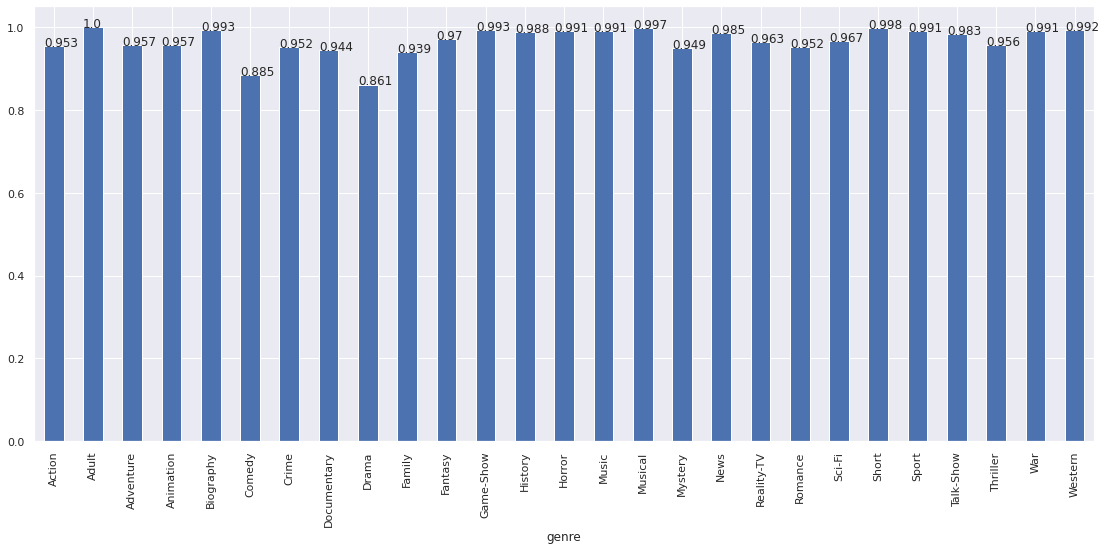

In [51]:
#plot the confusion matrix for "drama"

accuracy_list = []
for i in range(test_matrix.shape[0]):
  precision = test_matrix[i, 0, 0]/(test_matrix[i, 0, 0]+test_matrix[i, 0, 1])
  recall = test_matrix[i, 0, 0]/(test_matrix[i, 0, 0]+test_matrix[i, 1, 0])
  accuracy_list.append(2* precision * recall/(precision +recall))
accuracy_list = [round(num, 3) for num in accuracy_list]

categories = list(one_hot.columns.values)

df_acc = pd.DataFrame({'genre':categories, 'acc': accuracy_list}) 
ax = df_acc.plot(x='genre', y='acc', kind='bar', legend=False, grid=True, figsize=(19, 8))

for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()))

In [52]:
accuracy_list

[0.953,
 1.0,
 0.957,
 0.957,
 0.993,
 0.885,
 0.952,
 0.944,
 0.861,
 0.939,
 0.97,
 0.993,
 0.988,
 0.991,
 0.991,
 0.997,
 0.949,
 0.985,
 0.963,
 0.952,
 0.967,
 0.998,
 0.991,
 0.983,
 0.956,
 0.991,
 0.992]